# Exercise 05
## Lars Kühmichel, Nicolas Wolf

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

In [36]:
plt.rc("figure", dpi=150)
plt.rc("legend", fontsize=6)

## Task 2: Kalman Filter Smoother

In [37]:
import pathlib as pl

path = pl.Path("data")
pattern = "*.csv"

params = {}

for file in path.glob(pattern):
    params[file.stem] = np.genfromtxt(file, delimiter=",")

In [38]:
df = pd.DataFrame()
df["x1"] = params["x"][0, :]
df["x2"] = params["x"][1, :]
df["z1"] = params["z"][0, :]
df["z2"] = params["z"][1, :]

df.corr()

,x1,x2,z1,z2
x1,1.000000,-0.937791,0.975672,0.230114
x2,-0.937791,1.000000,-0.990942,0.120206
z1,0.975672,-0.990942,1.000000,0.013014
z2,0.230114,0.120206,0.013014,1.000000


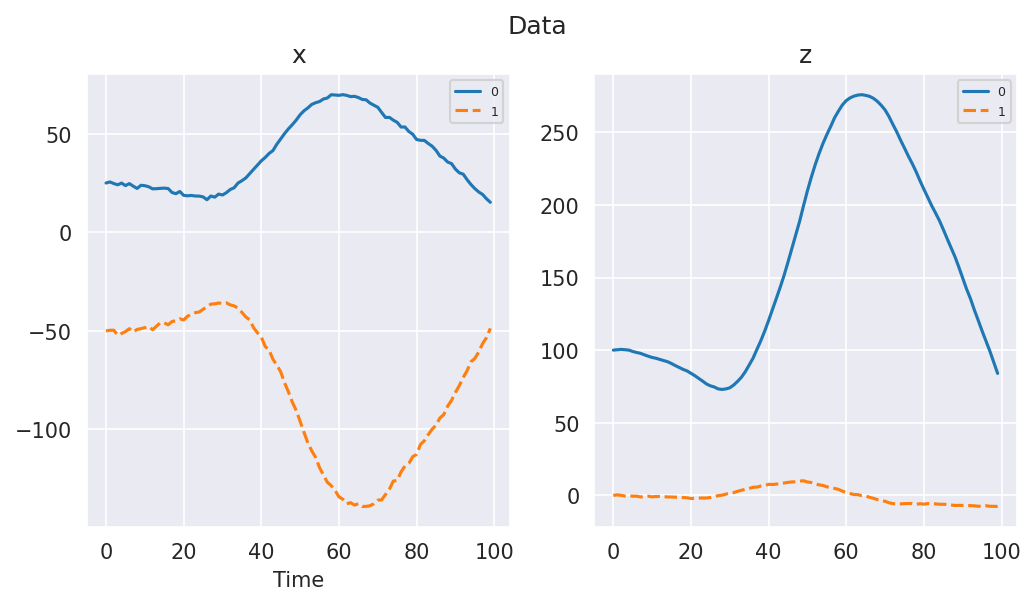

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.5), sharex="all")

sns.lineplot(data=params["x"].T, ax=axes[0])
sns.lineplot(data=params["z"].T, ax=axes[1])

fig.suptitle("Data")
axes[0].set_title("x")
axes[1].set_title("z")
axes[0].set_xlabel("Time")

plt.show()

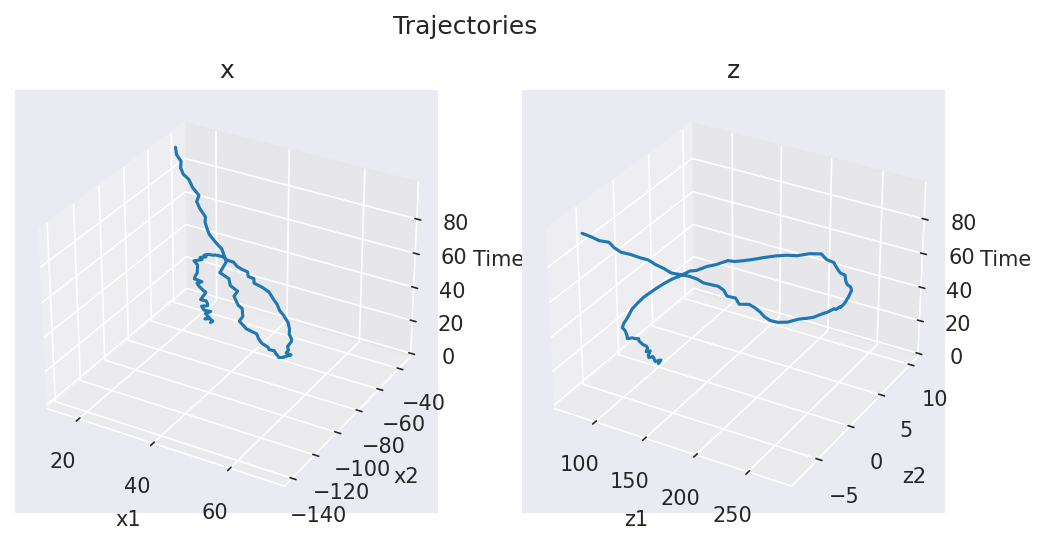

In [40]:
fig = plt.figure(figsize=plt.figaspect(0.5))
axes = [
    fig.add_subplot(1, 2, 1, projection="3d"),
    fig.add_subplot(1, 2, 2, projection="3d")
]

t = np.arange(params["x"].shape[1])
x = params["x"][0, :]
y = params["x"][1, :]
axes[0].plot(x, y, t)

x = params["z"][0, :]
y = params["z"][1, :]
axes[1].plot(x, y, t)

fig.suptitle("Trajectories")
axes[0].set_title("x")
axes[0].set_xlabel("x1")
axes[0].set_ylabel("x2")
axes[0].set_zlabel("Time")

axes[1].set_title("z")
axes[1].set_xlabel("z1")
axes[1].set_ylabel("z2")
axes[1].set_zlabel("Time")

plt.show()


### 1. Retrieve an estimate for the latent states $z$ purely from the observations $x$ by implementing Kalman-filter recursion.

In [41]:
def filter_kalman_step(mu, V, A, B, C, Gamma, Sigma, u, x):
    I = np.eye(mu.shape[0])
    L = A @ V @ A.T + Sigma
    K = L @ B.T @ np.linalg.inv(B @ L @ B.T + Gamma)
    mut = A @ mu + C * u + K @ (x - B  @ A @ mu)
    Vt = (I - K @ B) @ L

    return mut, Vt

def filter_kalman(mu0, V0, A, B, C, Gamma, Sigma, u, x):
    mu = [mu0]
    V = [V0]

    steps = len(x)
    for t in range(steps):
        mut, Vt = filter_kalman_step(mu[-1], V[-1], A, B, C, Gamma, Sigma, u[t], x[t])
        mu.append(mut)
        V.append(Vt)

    mu = np.array(mu)
    V = np.array(V)

    return mu, V

In [42]:
kalman_params = params.copy()
kalman_params.pop("L0")
kalman_params.pop("z")
kalman_params.pop("z0")

kalman_params["x"] = params["x"].T

# find out V0
LS = params["L0"] - params["Sigma"]
# should be symmetric
assert np.allclose(LS, LS.T)
# V0 is then the Sigma of the SVD
kalman_params["V0"] = np.diag(np.linalg.svd(LS, compute_uv=False, hermitian=True))

mu, V = filter_kalman(**kalman_params)

### 2. Plot the obtained predicted latent states against the true latent states.

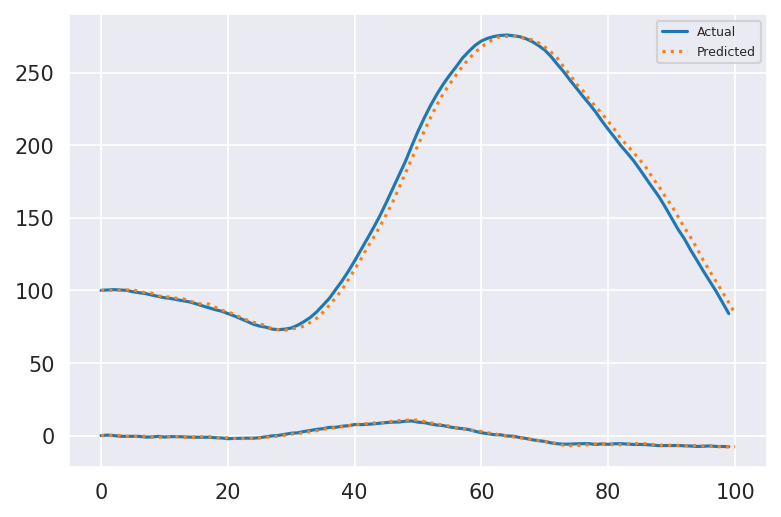

In [43]:
plt.plot(params["z"][0, :], color="C0", label="Actual")
plt.plot(params["z"][1, :], color="C0",)

plt.plot(mu[:, 0], color="C1", ls=":", label="Predicted")
plt.plot(mu[:, 1], color="C1", ls=":")

plt.legend()

### How well can you recover the true latent states?

The fit seems to be very good. We can confirm this with an $R^2$ test:

In [44]:
r2_score(params["z"].T, mu[1:])

0.9955938101196116

### What could the drone be doing?

Since $z$ is a position in space, we can assume that the drone is flying left-to-right and back (or front-to-back, etc. as we have no reference point), as could be seen from the 3D plots earlier.
We can only guess what $x_1$ and $x_2$ represent. They are likely measurement metrics from the drone's onboard instruments or controller inputs, e.g. throttle $(x_1)$ and pitch $(x_2)$.

### 3. Examine the parameter values of $A$ and $C$. Why are they chosen the way they are?

In [45]:
params["A"]

array([[1., 1.],
       [0., 1.]])

In [46]:
params["C"]

array([0.2, 1. ])

$A$ is likely chosen for Granger-causality. $z_2$ granger-causes $z_1$ but not vice versa. $C$ may represent the mean wind direction, i.e. the wind is five times stronger in $z_2$ direction than in $z_1$.

### 4. Now implement the Kalman-Smoother.

In [ ]:
def smooth_kalman_step(mu_tilde, V_tilde, mu, V, A, C, Sigma, u):
    L = A @ V @ A.T + Sigma
    L_inv = np.linalg.inv(L)
    Vt_tilde = V + V @ A.T @ L_inv @ (V_tilde - L) @ L_inv @ A @ V.T
    mut_tilde = mu + V @ A.T @ L_inv @ (mu_tilde - (A @ mu + C * u))

    return mut_tilde, Vt_tilde

def smooth_kalman(mu, V, A, C, Sigma, u):
    mu_tilde = [mu[-1]]
    V_tilde = [V[-1]]

    T = len(u)
    for i in range(1, T):
        t = T - i
        mut_tilde, Vt_tilde = smooth_kalman_step(mu[t], V[t], mu[t], V[t], A, C, Sigma, u[t])
        mu_tilde.append(mut_tilde)
        V_tilde.append(Vt_tilde)

    mu_tilde = np.array(mu_tilde[::-1])
    V_tilde = np.array(V_tilde[::-1])

    return mu_tilde, V_tilde

### 5. Apply the Kalman-filter-smoother to obtain estimates for your latent state path.

In [81]:
mu_tilde, V_tilde = smooth_kalman(mu[:-1], V[:-1], params["A"], params["C"], params["Sigma"], params["u"].T)

### Plot the obtained predicted latent states against the true latent states and against the latent states obtained by only using the filter.

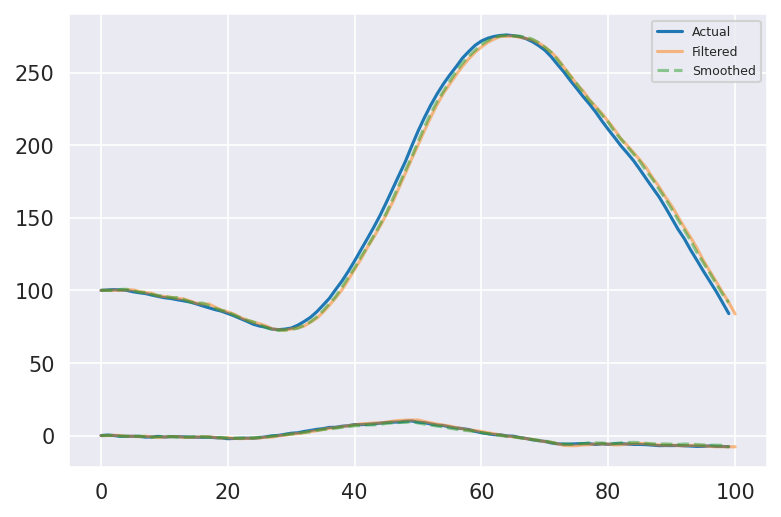

In [84]:
plt.plot(params["z"][0, :], color="C0", label="Actual")
plt.plot(params["z"][1, :], color="C0",)

plt.plot(mu[:, 0], color="C1", alpha=0.5, label="Filtered")
plt.plot(mu[:, 1], color="C1", alpha=0.5)

plt.plot(mu_tilde[:, 0], color="C2", ls="--", alpha=0.5, label="Smoothed")
plt.plot(mu_tilde[:, 1], color="C2", ls="--", alpha=0.5)

plt.legend()

Text(0.5, 0.98, 'Smoothed Over Filtered Values')

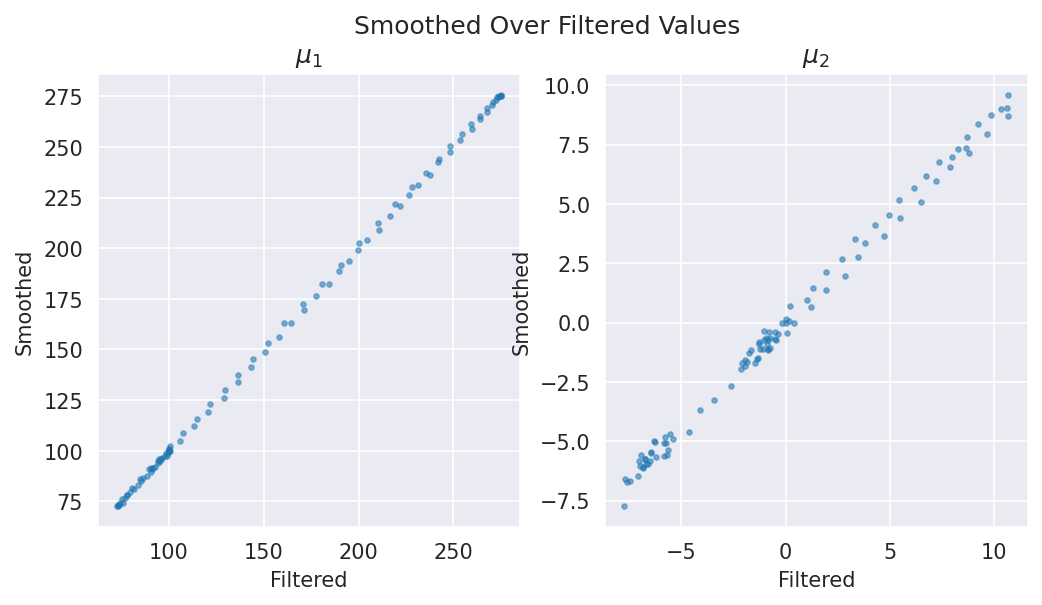

In [80]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.5))

axes[0].scatter(mu[:-1, 0], mu_tilde[:, 0], s=5, alpha=0.5)
axes[1].scatter(mu[:-1, 1], mu_tilde[:, 1], s=5, alpha=0.5)

axes[0].set_title(r"$\mu_1$")
axes[1].set_title(r"$\mu_2$")

axes[0].set_xlabel("Filtered")
axes[1].set_xlabel("Filtered")
axes[0].set_ylabel("Smoothed")
axes[1].set_ylabel("Smoothed")

fig.suptitle("Smoothed Over Filtered Values")